## Deep Learning
### Assignment 1

学习简单的数据处理经验， 熟悉以后常用的数据集

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

本文使用notMNIST数据集用于实践. 
这个数据集与经典的MNIST数据集相似，但是更接近生活中的数据，更加难以处理，并且没有MNIST‘干净’。

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [12]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [13]:
# 首先，我们会下载数据集到本地电脑。
# 所有的图片都是28*28像素的图片，标示为"A"到"J"（10个分类）。
# 整个数据集合包含大概50000个训练数据和19000个测试数据，所以这样规模的数据集合可以在大多数电脑上较快的完成训练。
# 训练数据文件名是notMNIST_large.tar.gz，测试数据文件名是notMNIST_small.tar.gz。
# url = 'https://commondatastorage.googleapis.com/books1000/'
url = 'http://yaroslavvb.com/upload/notMNIST/'
last_percent_reported = None
data_root = '.'  # Change me to store data elsewhere


def download_progress_hook(count, blockSize, totalSize):
    """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
    """
    一个钩子报告下载进度，这通常计划用于慢速网络连接，每5%报告下载进度
    """
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)

    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()

        last_percent_reported = percent


def maybe_download(filename, expected_bytes, force=False):
    """不存在就下载文件, 确保正确的文件大小."""
    dest_filename = os.path.join(data_root, filename)
    if force or not os.path.exists(dest_filename):
        print('正在下载：', filename)
        filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
        print('\n 下载成功!')
    statinfo = os.stat(dest_filename)
    if statinfo.st_size == expected_bytes:
        print('发现并验证：', dest_filename)
    else:
        raise Exception(
            '验证失败： ' + dest_filename + '。 你可以通过浏览器找到它么？')
    return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

发现并验证： ./notMNIST_large.tar.gz
发现并验证： ./notMNIST_small.tar.gz


In [14]:
# 解压数据集合，会产生一系列标记从A到J的目录。
num_classes = 10
np.random.seed(133)


def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    if os.path.isdir(root) and not force:
        # You may override by setting force=True.
        print('%s 已经存在 - 跳过提取 %s.' % (root, filename))
    else:
        print('从 %s 提取数据. 请等待.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall(data_root)
        tar.close()
    data_folders = [
        os.path.join(root, d) for d in sorted(os.listdir(root))
        if os.path.isdir(os.path.join(root, d))]
    if len(data_folders) != num_classes:
        raise Exception(
            '预计 %d 个文件夹, one per class. Found %d instead.' % (
                num_classes, len(data_folders)))
    print(data_folders)
    return data_folders

train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

./notMNIST_large 已经存在 - 跳过提取 ./notMNIST_large.tar.gz.
['./notMNIST_large/A', './notMNIST_large/B', './notMNIST_large/C', './notMNIST_large/D', './notMNIST_large/E', './notMNIST_large/F', './notMNIST_large/G', './notMNIST_large/H', './notMNIST_large/I', './notMNIST_large/J']
./notMNIST_small 已经存在 - 跳过提取 ./notMNIST_small.tar.gz.
['./notMNIST_small/A', './notMNIST_small/B', './notMNIST_small/C', './notMNIST_small/D', './notMNIST_small/E', './notMNIST_small/F', './notMNIST_small/G', './notMNIST_small/H', './notMNIST_small/I', './notMNIST_small/J']


---
## Problem 1


我们现在来看一下部分数据的内容。 
文件夹A中的图片类型都是png格式。 
每个图片中的字符的字体大小不尽相同。 
可以用IPython.display显示图片进行查看。

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [15]:
# 显示A下面的前20个图片
fn = os.listdir("notMNIST_small/A/")
for file in fn[:2]:
    path = 'notMNIST_small/A/' + file
    display(Image(path))

现在我们用一种更具操作性的方式载入图片数据。 
我们没必要将所有数据载入内存。 
可以分别载入每个类型的数据，存储在硬盘上分别处理。 
之后，汇总到一个可具操作性的数据集中。

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

我们要转换整个数据集为一个3维数组，每个维度分别是image index, x, y.所有值为浮点数，归一化后近似于均值为0的正太分布，并且方差在0.5左右。 
这样训练数据会进行的更加容易。

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road.

其中一些图像不能读取，对我们的结果不会有很大影响。

A few images might not be readable, we'll just skip them.

In [16]:
image_size = 28  # 宽和高的像素.
pixel_depth = 255.0  # 每个像素的深度，0-255

def load_letter(folder, min_num_images):
  """从单个字母标签读取数据."""
# folder = ./notMNIST_large/A
# min_num_images 准备读取多少个图片

# 具体的图片文件名 image_files ='a2VhZ2FuLnR0Zg==.png'
  image_files = os.listdir(folder)
# shape(具体某个字母类型下的文件数量，宽，高)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  num_images = 0
# 遍历某字母下的所有图片
  for image in image_files:
#     if(num_images <1):
# image_file = ./notMNIST_large/A + 具体图片名
        image_file = os.path.join(folder, image)
        try:
#         图像处理，变成（原像素值变成float类型后 - 255/2）／255
          image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
#           print(pixel_depth / 2)
#           print(image_data)
#         ndimage.imread(image_file).astype(float) 是把每个图片的每个像素点都变成单精度数字，-255/2 之后再 ／255
#           print("num_images="+str(num_images))
#           print(ndimage.imread(image_file).astype(float)) 
#     如果图片等长宽超出设定值
          if image_data.shape != (image_size, image_size):
            raise Exception('意外到图片形状: %s' % str(image_data.shape))
    #     dataset的类型是numpy.ndarray
          dataset[num_images, :, :] = image_data
          num_images = num_images + 1
        except IOError as e:
          print('不能读取:', image_file, ':', e, ' 没关系, 跳过.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('少于预期的图像: %d < %d' %
                    (num_images, min_num_images))
# 数据集的张量: (52911, 28, 28)
# 数据集的平均值: -0.00756303
# 数据集的标准差: 0.454491
  print('完整的数据集张量:', dataset.shape)
  print('平均值:', np.mean(dataset))
  print('标准差:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
# data_folders,数据集
# 
  for folder in data_folders:
#   folder = ./notMNIST_large/A
#   拼接文件名
    set_filename = folder + '.pickle'
#     把A-J的pickle文件名，放入数组
    dataset_names.append(set_filename)
#     判断文件是否存在和参数是否要求覆盖
    if os.path.exists(set_filename) and not force:
      # 通过设置force=True来覆盖文件
      print('%s 已经存在 - 跳过pickling文件.' % set_filename)
    else:
      print('Pickling文件 %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('无法保存数据集到', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

./notMNIST_large/A.pickle 已经存在 - 跳过pickling文件.
./notMNIST_large/B.pickle 已经存在 - 跳过pickling文件.
./notMNIST_large/C.pickle 已经存在 - 跳过pickling文件.
./notMNIST_large/D.pickle 已经存在 - 跳过pickling文件.
./notMNIST_large/E.pickle 已经存在 - 跳过pickling文件.
./notMNIST_large/F.pickle 已经存在 - 跳过pickling文件.
./notMNIST_large/G.pickle 已经存在 - 跳过pickling文件.
./notMNIST_large/H.pickle 已经存在 - 跳过pickling文件.
./notMNIST_large/I.pickle 已经存在 - 跳过pickling文件.
./notMNIST_large/J.pickle 已经存在 - 跳过pickling文件.
./notMNIST_small/A.pickle 已经存在 - 跳过pickling文件.
./notMNIST_small/B.pickle 已经存在 - 跳过pickling文件.
./notMNIST_small/C.pickle 已经存在 - 跳过pickling文件.
./notMNIST_small/D.pickle 已经存在 - 跳过pickling文件.
./notMNIST_small/E.pickle 已经存在 - 跳过pickling文件.
./notMNIST_small/F.pickle 已经存在 - 跳过pickling文件.
./notMNIST_small/G.pickle 已经存在 - 跳过pickling文件.
./notMNIST_small/H.pickle 已经存在 - 跳过pickling文件.
./notMNIST_small/I.pickle 已经存在 - 跳过pickling文件.
./notMNIST_small/J.pickle 已经存在 - 跳过pickling文件.


---
## Problem 2

检验图片数据经过处理后数据是不是完好如初。利用matplotlib.pyplot 显示图片

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

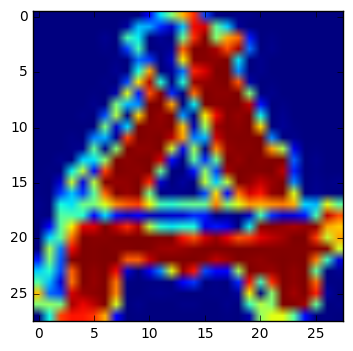

In [17]:
# index 0 should be all As, 1 = all Bs, etc.
pickle_file = train_datasets[0]  
# 嵌套代码完成后会自动关闭文件 
with open(pickle_file, 'rb') as f:
    # f = ./notMNIST_large/A.pickle
    # 获取图片数据集
    letter_set = pickle.load(f)  
    
    # 随机挑选图像索引
    # sample_idx = 随机某个图片ID
    sample_idx = np.random.randint(len(letter_set))
    #     print(sample_idx)
    # 提取某个数据集
    #     print(type(letter_set))
    #     sample_image是某图片的处理后的所有像素值，只有1个冒号表示取得所有数据，这里是宽和高
    sample_image = letter_set[sample_idx, :, :]  
#     plt.figure()
    
    # display it
    plt.imshow(sample_image)
    plt.show()

---
## Problem 3


另一个验证：我们期望数据在各个类之间是平衡的。验证数据

Another check: we expect the data to be balanced across classes. Verify that.

---

In [18]:
# 打印各个字母类别的数量
pickle_file = 'notMNIST_large/{0}.pickle'
for ele in 'ABCDEFJHIJ':
    with open(pickle_file.format(ele), "rb") as pk_f:
#         pk_f = notMNIST_large/A.pickle
#         读取传入的pickle文件
        dat = pickle.load(pk_f)
        count = len(dat)
        print("{}.pickle的数量是：".format(ele),count)

A.pickle的数量是： 52909
B.pickle的数量是： 52911
C.pickle的数量是： 52912
D.pickle的数量是： 52911
E.pickle的数量是： 52912
F.pickle的数量是： 52912
J.pickle的数量是： 52911
H.pickle的数量是： 52912
I.pickle的数量是： 52912
J.pickle的数量是： 52911


根据需要合并和修建训练数据

Merge and prune the training data as needed. 

取决于你的电脑配置，你可能不能容纳所有数据到内存，并且根据需要你可以调整训练尺寸

Depending on your computer setup, you might not be able to fit it all in memory, and you can tune train_size as needed. 

标签将存储不同的数列放到整数0-9内

The labels will be stored into a separate array of integers 0 through 9.

为调整超参数创建一个验证数据集

Also create a validation dataset for hyperparameter tuning.

In [19]:
# 创建验证数据集
# 根据行数和图片尺寸创建ndarray，返回dataset是图片数量，宽，高，labels是图片数量大小
def make_arrays(nb_rows, img_size):
    
    if nb_rows:
        dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
        labels = np.ndarray(nb_rows, dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
#     文件长度
    num_classes = len(pickle_files)
#     验证数据集大小 ，验证层次数据大小
    valid_dataset, valid_labels = make_arrays(valid_size, image_size) 
#     训练数据集大小 ，训练层次数据大小
    train_dataset, train_labels = make_arrays(train_size, image_size)
    vsize_per_class = valid_size // num_classes    #  choose vsize_per_class from each class for validation
    tsize_per_class = train_size // num_classes    # choose tsize_per_class from each class for trainment
#     vsize_per_class=1000,valid_size=10000,num_classes=10
#     vsize_per_class=0,valid_size=0,num_classes=10
#     tsize_per_class=20000,train_size=200000,num_classes=10
#     tsize_per_class=1000,train_size=10000,num_classes=10
    print("vsize_per_class={0},valid_size={1},num_classes={2:d}".format(vsize_per_class,valid_size,num_classes))
    print("tsize_per_class={0},train_size={1},num_classes={2:d}".format(tsize_per_class,train_size,num_classes))
#     定义开始到结束的范围
    start_v, start_t = 0, 0

    end_v, end_t = vsize_per_class, tsize_per_class

    end_l = vsize_per_class+tsize_per_class
    for label, pickle_file in enumerate(pickle_files):
#         print(label)
        try:
#             f = notMNIST_large/A.pickle
            with open(pickle_file, 'rb') as f:
#                 读取传入的pickle文件
                letter_set = pickle.load(f)
#             让我们把验证和训练集随机洗牌
#             np.random.shuffle就是把数据集里的数据顺序随机排列
            np.random.shuffle(letter_set)
#             把测试和训练数据集分别写入到验证数据集，并且把数据开始和结束标志移动到现有已经写入到数据之后
            if valid_dataset is not None:
#                 范围都是0-1000（第一次）
#                 print("----valid-----")
#                 print(vsize_per_class)
#                 print(start_v)
#                 print(end_v)
                valid_letter = letter_set[:vsize_per_class, :, :]
                valid_dataset[start_v:end_v, :, :] = valid_letter
                valid_labels[start_v:end_v] = label
                start_v += vsize_per_class
                end_v += vsize_per_class

        
                
#             把除了写入到验证数据之外的数据，放到训练集
#             print("----train-----")
#             print(vsize_per_class)
#             print(end_l)
#             print(start_t)
#             print(end_t)
#             1000-21000
            train_letter = letter_set[vsize_per_class:end_l, :, :]
#             0-20000
            train_dataset[start_t:end_t, :, :] = train_letter
            train_labels[start_t:end_t] = label
            start_t += tsize_per_class
            end_t += tsize_per_class
        except Exception as e:
            print('Unable to process data from', pickle_file, ':', e)
            raise

    return valid_dataset, valid_labels, train_dataset, train_labels

# 训练数据大小
train_size = 200000
# 验证数据大小
valid_size = 10000
# 测试数据大小
test_size = 10000
image_size = 28  # 图片像素宽和高 28 X 28
# 训练数据集
train_datasets  = [ele.join(['notMNIST_large/','.pickle'] )  for ele in  list('ABCDEFGHIJ') ]
# 测试数据集
test_datasets  = [ele.join(['notMNIST_small/','.pickle'] )   for ele in list('ABCDEFGHIJ')  ]

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('训练集:', train_dataset.shape, train_labels.shape)
print('验证集:', valid_dataset.shape, valid_labels.shape)
print('测试集:', test_dataset.shape, test_labels.shape)

vsize_per_class=1000,valid_size=10000,num_classes=10
tsize_per_class=20000,train_size=200000,num_classes=10
vsize_per_class=0,valid_size=0,num_classes=10
tsize_per_class=1000,train_size=10000,num_classes=10
训练集: (200000, 28, 28) (200000,)
验证集: (10000, 28, 28) (10000,)
测试集: (10000, 28, 28) (10000,)


接下来，我们要随机这个数据集。重要的是标签随机让训练和测试的数据重新分配

Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [20]:
# 随机顺序
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
## Problem 4

说服你自己数据洗牌后还是好数据

Convince yourself that the data is still good after shuffling!

---

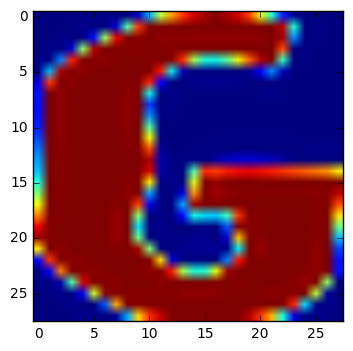

the picture should be   G


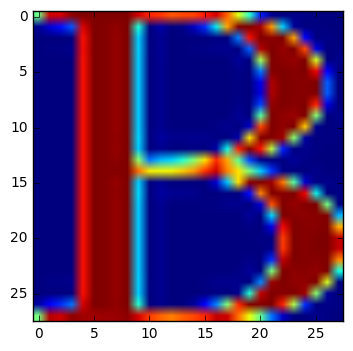

the picture should be   B


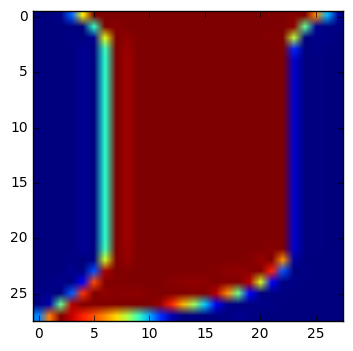

the picture should be   J


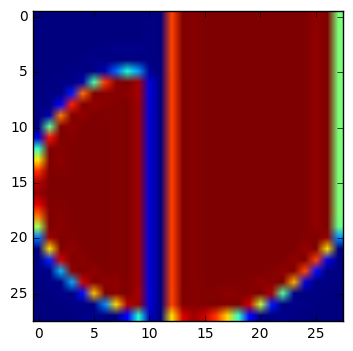

the picture should be   J


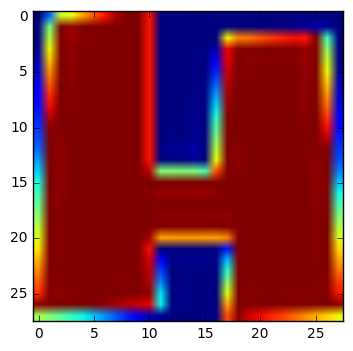

the picture should be   H


In [21]:
# 验证随机打乱后到数据集是否正常
# from six.moves import xrange
mapping = {key:val for key, val in enumerate('ABCDEFGHIJ')}

def plot_check(matrix, key):
    plt.imshow(matrix)
    plt.show()
    print('the picture should be  ', mapping[key])
    return None

length = train_dataset.shape[0]-1
# five check
for _ in range(5):
#     随机训练长度内的索引
    index = np.random.randint(length)
    plot_check(train_dataset[index,:,:], train_labels[index])
    



最终，让我们保存这些数据用来以后重用

Finally, let's save the data for later reuse:

In [22]:
# 拼接数据路径./notMNIST.pickle
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

# 把训练，验证，测试数据集都写入到一个文件
try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
#     保存文件，pickle.HIGHEST_PROTOCOL是高压缩
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('不能保存文件', pickle_file, ':', e)
  raise

In [23]:
statinfo = os.stat(pickle_file)
print('压缩后的pickle的文件大小:'+str(statinfo.st_size/1024/1024)+"M")

压缩后的pickle的文件大小:658.7987003326416M


---
## Problem 5

按照说明，这个数据集可能包括大量重叠的样本，包括验证和测试数据集在内的训练数据！

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! 

训练和测试之间的重叠会结果的影响准确性，如果你期望使用你的模型环境没有重叠数据。（如果你期望在没有重叠的环境中使用你的模型），但是事实上如果你期待看到训练样本重现，当你使用它的时候

Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it. 

测量有多少重叠在训练，验证和测试样本之间

Measure how much overlap there is between training, validation and test samples.

可选问题：
- 那么数据集之间的近似副本？（几乎相同的图片）
- 创建一个净化校验和测试数据，并且比较那些后续任务的准确度

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.

---

In [4]:
#  这一步用时太长
import multiprocessing as mp
import numpy as np
import collections


def check_overlap(dataset1, start, end, dataset2, q):
    '''
     计算数据的数字比较dataset1是否存在于dataset2从start 到 end]
    '''
    overlappingindex = []
    length1 = dataset1.shape[0]
    for i in range(length1):
        for j in range(start, end):
            error = np.sum(np.sum(np.abs(dataset1[i,:,:]-dataset2[j,:,:])))
            if error < 0.2:
                overlappingindex.append((i,j))
                break
    q.put(tuple(overlappingindex))
    return None



print('start loading notMNIST.pickle')
with open('notMNIST.pickle', 'rb') as f:
    data = pickle.load(f)
print('loading finished.')
q = mp.Queue()
train_dataset = data['train_dataset']
valid_dataset = data['valid_dataset']
length = train_dataset.shape[0]
idx = (0, int(length*1.0/3), int(length*2.0/3), length)
processes = []
for i in range(1):
    processes.append(mp.Process(target=check_overlap, args=(valid_dataset, idx[i], idx[i+1], train_dataset, q)))
# 再通过p.start()来启动子进程
for p in processes:
    p.start()
# 再通过p.join()方法来使得子进程运行结束后再执行父进程
for p in processes:
    p.join()
results = []
while not q.empty():
    results.append(q.get())
print(results)
func  = lambda x: [i  for xs in x for i in func(xs)] if isinstance(x,collections.Iterable) else [x]
print(func(results))

start loading notMNIST.pickle
loading finished.
[((1, 16063), (11, 16236), (12, 1309), (23, 18368), (32, 2868), (35, 19007), (46, 737), (51, 14598), (71, 8162), (73, 6091), (84, 10882), (95, 14944), (102, 16793), (117, 16199), (119, 12057), (120, 14250), (130, 521), (134, 7422), (142, 2663), (166, 12879), (180, 17728), (185, 7007), (213, 6907), (239, 18889), (255, 6633), (264, 4939), (265, 7109), (268, 18717), (300, 8834), (307, 10273), (318, 10092), (327, 3623), (332, 19538), (352, 5177), (358, 11164), (361, 19560), (363, 10671), (369, 3647), (384, 6401), (389, 6722), (398, 1007), (415, 3825), (434, 13272), (474, 15316), (493, 1807), (495, 7500), (497, 7950), (499, 3870), (506, 375), (521, 1158), (537, 773), (538, 4922), (552, 804), (557, 12142), (558, 10693), (559, 13142), (565, 12873), (570, 4161), (598, 18741), (607, 14005), (616, 17640), (618, 19202), (678, 9167), (679, 11477), (687, 2708), (701, 19862), (709, 16344), (714, 9153), (725, 11446), (730, 1169), (739, 12473), (741, 608

---
## Problem 6

让我们来了解现成的分类器能给你什么样的数据

Let's get an idea of what an off-the-shelf classifier can give you on this data. 

一直高水准的检查是否有需要学习的东西，这个问题不是微不足道的，通过预处理解决处理它

It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

用50,100,1000,5000数量的样本训练一个简单的模型

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. 

提示：你能使用逻辑回归模型（sklearn.linear_model）

Hint: you can use the LogisticRegression model from sklearn.linear_model.

可选问题：在所有数据上训练现有的模型

Optional question: train an off-the-shelf model on all the data!

---

In [ ]:
from sklearn.linear_model import LogisticRegression
# import cPickle as pickle
import numpy as np
size = 50
image_size =28
# loading data 
print('读取数据')
with open('notMNIST.pickle', 'rb') as f:
    data  =  pickle.load(f)
print('读取完成')
train_dt = data['train_dataset']
length = train_dt.shape[0]
train_dt = train_dt.reshape(length, image_size*image_size)
train_lb = data['train_labels']
test_dt = data['test_dataset']
length = test_dt.shape[0]
test_lb = data['test_labels']
test_dt = test_dt.reshape(length, image_size*image_size)
def train_linear_logistic(tdata, tlabel):

    model = LogisticRegression(C=1.0, penalty='l1')

    print('初始化模型大小 = {}'.format(size))
#     print(tlabel[:size])
    model.fit(tdata[:size,:], tlabel[:size])

    print('测试模型')
    y_out = model.predict(test_dt)

    print('模型精度在数量 = {} 是 {}'.format(size, np.sum(y_out == test_lb)*1.0/len(y_out) ))

    return None
# print(train_dt)
train_linear_logistic(train_dt, train_lb)
size = 100
train_linear_logistic(train_dt, train_lb)
size = 1000
train_linear_logistic(train_dt, train_lb)
size = 5000
train_linear_logistic(train_dt, train_lb)

In [7]:
from sklearn.linear_model import LogisticRegression
# import cPickle as pickle
import numpy as np
import pickle
size = 50
image_size =28
# loading data 
print('读取数据')
import gzip
f = gzip.open("mnist.pkl.gz", "rb")
train, val, test = pickle.load(f, encoding='bytes')
f.close()
# train_x = train[0]
# train_y = train[1]
# test_x = test[0]
# test_y = test[1]

# print(train.shape)
print('读取完成')
train_dt = train[0]
length = train_dt.shape[0]
train_dt = train_dt.reshape(length, image_size*image_size)
train_lb = train[1]
test_dt = test[0]
length = test_dt.shape[0]
test_lb = test[1]
test_dt = test_dt.reshape(length, image_size*image_size)
def train_linear_logistic(tdata, tlabel):

    model = LogisticRegression(C=1.0, penalty='l1')

    print('初始化模型大小 = {}'.format(size))
#     print(tlabel[:size])
    model.fit(tdata[:size,:], tlabel[:size])

    print('测试模型')
    y_out = model.predict(test_dt)

    print('模型精度在数量 = {} 是 {}'.format(size, np.sum(y_out == test_lb)*1.0/len(y_out) ))

    return None
# print(train_dt)
train_linear_logistic(train_dt, train_lb)
size = 100
train_linear_logistic(train_dt, train_lb)
size = 1000
train_linear_logistic(train_dt, train_lb)
size = 5000
train_linear_logistic(train_dt, train_lb)

读取数据
读取完成
初始化模型大小 = 50
测试模型
模型精度在数量 = 50 是 0.5655
初始化模型大小 = 100
测试模型
模型精度在数量 = 100 是 0.6191
初始化模型大小 = 1000
测试模型
模型精度在数量 = 1000 是 0.8564
初始化模型大小 = 5000
测试模型
模型精度在数量 = 5000 是 0.8954
